In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
import umap
import hdbscan

# Functions

In [2]:
def load_dataset(file_path):
    return pd.read_pickle(file_path)

In [3]:
def drop_nan_rows(df, column):
    df = df.dropna(subset=[column])
    df = df[df[column] != "nan"]
    df = df[df[column] != ""]
    return df

In [4]:
def create_embedding_matrix(df, column):
    embedding_matrix = np.vstack(df[column].values)
    return embedding_matrix

In [5]:
def tsne_transform(
    df, embedding_matrix, perplexity=17, max_iter=10000, random_state=42
):
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        max_iter=max_iter,
        random_state=random_state,
    )
    embeddings_2d = tsne.fit_transform(embedding_matrix)
    df = df.copy()
    df.loc[:, "tsne_x"] = embeddings_2d[:, 0]
    df.loc[:, "tsne_y"] = embeddings_2d[:, 1]
    return df, embeddings_2d

In [6]:
def generate_kmeans_clusters(df, embedding_matrix, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, max_iter=10000, random_state=42)
    df["cluster"] = kmeans.fit_predict(embedding_matrix)
    return df

In [7]:
nltk.download("stopwords", quiet=True)

# Load Portuguese stopwords
portuguese_stopwords = stopwords.words("portuguese")
additional_stopwords = [
    "pra",
    "pro",
    "tá",
    "já",
    "ter",
    "vai",
    "vou",
    "então",
    "assim",
    "aí",
    "sobre"
]
portuguese_stopwords.extend(additional_stopwords)

In [8]:
def get_cluster_words(df_preprocessed, column):
    tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words=portuguese_stopwords)
    cluster_top_terms = {}
    for c in sorted(df_preprocessed["cluster"].unique()):
        cluster_texts = df_preprocessed[df_preprocessed["cluster"] == c][column]
        tfidf_matrix = tfidf.fit_transform(cluster_texts)
        terms = tfidf.get_feature_names_out()
        scores = tfidf_matrix.sum(axis=0).A1
        top_terms = sorted(zip(terms, scores), key=lambda x: -x[1])[:20]
        cluster_top_terms[c] = top_terms
        print(f"\nCluster {c}:")
        print([term for term, _ in top_terms])
    return cluster_top_terms

In [9]:
def get_wordcloud(cluster_top_terms):
    combined_word_freq = {}
    for c, terms in cluster_top_terms.items():
        for term, score in terms:
            if term in combined_word_freq:
                combined_word_freq[term] += score
            else:
                combined_word_freq[term] = score

    wc = WordCloud(
        width=1200, height=800, background_color="white"
    ).generate_from_frequencies(combined_word_freq)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Combined Word Cloud for All Clusters")
    plt.show()

In [10]:
def visualize_clusters(df, n_clusters=5):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x="tsne_x",
        y="tsne_y",
        hue="cluster",
        palette="tab20",
        legend=None,
        s=40,
    )
    plt.title("t-SNE visualization of clusters")
    plt.show()

In [11]:
def run_workflow(df, df_preprocessed, column, n_clusters=5):
    print(f"DF shape: {df.shape}")
    
    # Reset indices to avoid duplicate index issues
    df = df.reset_index(drop=True)
    df_preprocessed = df_preprocessed.reset_index(drop=True)
    
    embedding_matrix = create_embedding_matrix(df, f"{column}_embedding")
    df, embeddings_2d = tsne_transform(df, embedding_matrix)
    df = generate_kmeans_clusters(df, embedding_matrix, n_clusters)

    df_preprocessed = df_preprocessed.copy()
    df_preprocessed["cluster"] = df["cluster"]

    cluster_top_terms = get_cluster_words(df_preprocessed, column)
    get_wordcloud(cluster_top_terms)
    visualize_clusters(df, n_clusters)

In [12]:
def all_status_workflow(df, df_preprocessed, column, n_clusters=5):
    run_workflow(df, df_preprocessed, column, n_clusters=n_clusters)

# Define Files

In [13]:
file_path = "../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl"
column = "response"

In [14]:
df = load_dataset(file_path)
df = drop_nan_rows(df, column)
df

datetime        sex      adhd_diagnosis  age  \
1    2025-03-30T16:29:47+02:00   Feminino           Não tenho   22   
3    2025-03-31T12:08:00+02:00   Feminino           Não tenho   23   
8    2025-03-31T12:55:43+02:00   Feminino           Não tenho   19   
14   2025-03-31T13:54:40+02:00   Feminino           Não tenho   25   
15   2025-03-31T13:58:15+02:00   Feminino  Suspeito que tenho   25   
..                         ...        ...                 ...  ...   
293  2025-06-07T16:05:17+02:00   Feminino  Sim, diagnosticado   51   
296  2025-06-07T17:23:10+02:00   Feminino  Sim, diagnosticado   36   
307  2025-06-10T16:58:08+02:00   Feminino  Sim, diagnosticado   19   
308  2025-06-10T17:45:28+02:00  Masculino  Sim, diagnosticado   19   
312  2025-06-10T23:09:33+02:00   Feminino  Suspeito que tenho   20   

             education             occupation                dialect  \
1         Licenciatura              Estudante  Português de Portugal   
3             Mestrado  Trabalhador-estudante  Português de Portugal   
8         Licenciatura              Estudante  Português de Portugal   
14            Mestrado            Trabalhador  Português de Portugal   
15        Licenciatura            Trabalhador  Português de Portugal   
..                 ...                    ...                    ...   
293           Mestrado  Trabalhador-estudante  Português de Portugal   
296      Pós-Graduação              Estudante  Português de Portugal   
307  Ensino secundário  Trabalhador-estudante  Português de Portugal   
308  Ensino secundário              Estudante  Português de Portugal   
312  Ensino secundário              Estudante  Português de Portugal   

    forgetting_objects forgetting_responsabilities emotion_management  ...  \
1                    3                           3                  4  ...   
3                    2                           1                  4  ...   
8                    3                           2                  2  ...   
14                   4                           3                  4  ...   
15                   4                           2                  5  ...   
..                 ...                         ...                ...  ...   
293                  4                           2                  5  ...   
296                  5                           3                  3  ...   
307                  4                           2                  4  ...   
308                  2                           3                  4  ...   
312                  4                           2                  4  ...   

    need_fast_talk_interest need_fast_talk_information  \
1                         1                          1   
3                         1                          1   
8                         4                          4   
14                        2                          3   
15                        2                          2   
..                      ...                        ...   
293                       3                          2   
296                       2                          3   
307                       4                          4   
308                       1                          1   
312                       1                          1   

    speaking_before_thinking something_to_add something_to_add_timid  \
1                          3                4                      4   
3                          4                4                      4   
8                          2                4                      3   
14                         3                5                      4   
15                         3                5                      5   
..                       ...              ...                    ...   
293                        4                4                      5   
296                        3                4                      3   
307                        4      

## Women with ADHD vs. Others

In [15]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_women_adhd

df_women_adhd = df[mask_women_adhd]
df_others = df[mask_others]

DF shape: (65, 61)

Cluster 0:
['tudo', 'saúde', 'tão', 'interesse', 'geral', 'especial', 'interesse especial', 'cinema', 'cinema surrealismo', 'minerais', 'minerais música', 'música', 'música cinema', 'necrópoles', 'necrópoles minerais', 'pedras', 'pedras necrópoles', 'surrealismo', 'incrível', 'mundo']

Cluster 1:
['dia', 'porque', 'pessoas', 'hoje', 'consigo', 'sinto', 'bem', 'vida', 'ainda', 'percebi', 'nunca', 'pq', 'comigo', 'trabalho', 'adoro', 'fazer', 'cansada', 'acordei', 'sei', 'memória']

Cluster 2:
['fazer', 'prefiro', 'prefiro fazer', 'correr', 'gosto', 'gosto correr', 'consigo', 'consigo dar', 'consigo escrever', 'continuidade', 'dar', 'dar continuidade', 'diário', 'diário porque', 'escrever', 'escrever diário', 'porque', 'porque consigo']

Cluster 3:
['phda', 'nada', 'pessoas', 'entristece', 'tudo', 'comportamento', 'sindicalista', 'perceber', 'anos', 'vida', 'sempre', 'comportamento pessoas', 'perceber comportamento', 'psicologia', 'psicologia perceber', '40', '40 anos

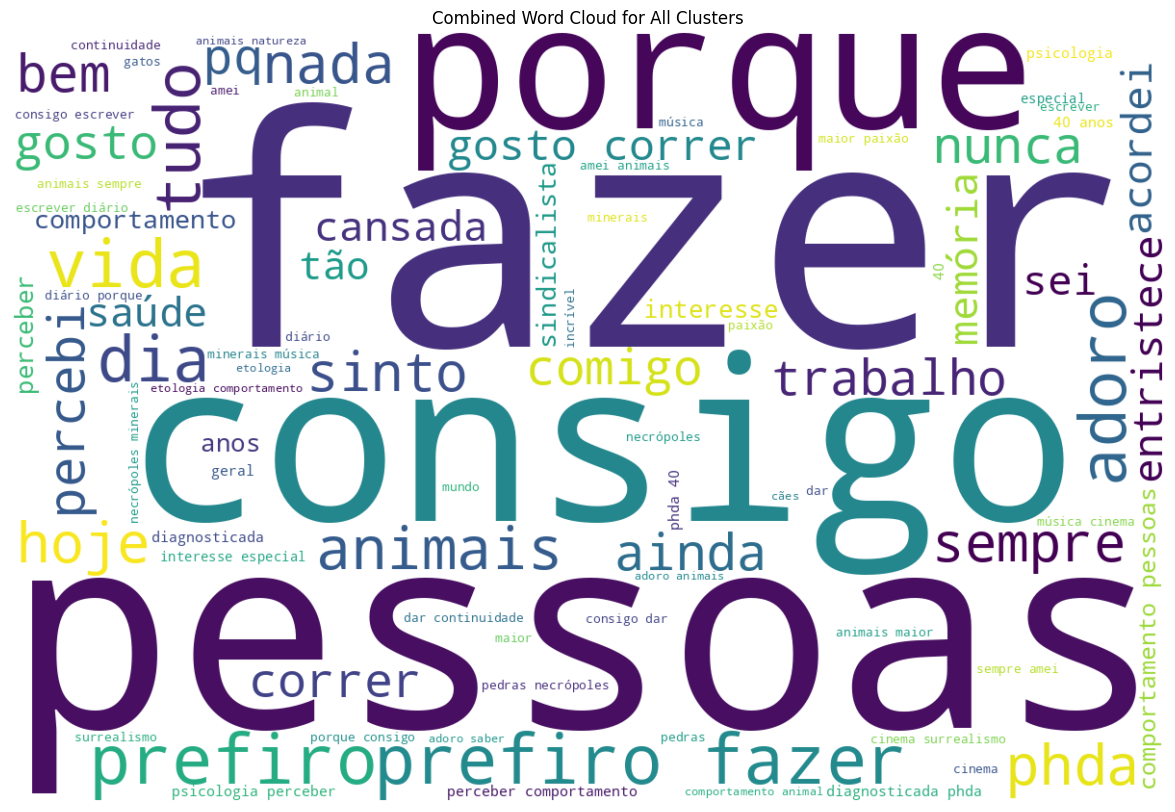

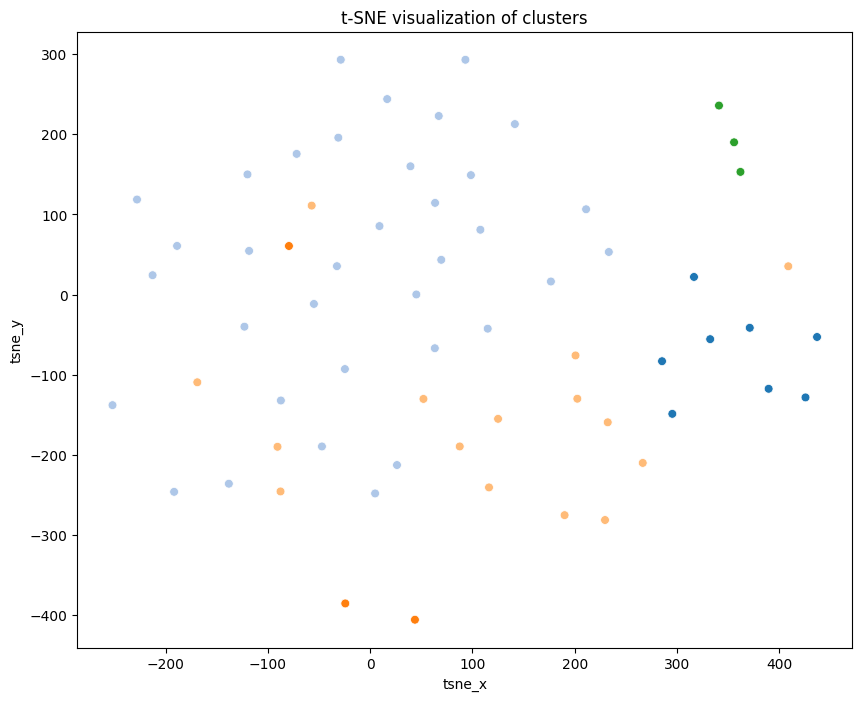

In [16]:
all_status_workflow(df_women_adhd, df_women_adhd, column, n_clusters=5)

DF shape: (382, 61)

Cluster 0:
['anos', 'sempre', 'memória', 'lembro', 'pessoas', 'pai', 'dia', 'porque', 'fazer', 'mim', 'hoje', 'algo', 'nunca', 'pessoa', 'mãe', 'fez', 'vezes', 'ainda', 'tudo', 'vez']

Cluster 1:
['dia', 'fazer', 'porque', 'hoje', 'trabalho', 'casa', 'tempo', 'ir', 'tarde', 'senti', 'bem', 'trabalhar', 'manhã', 'ainda', 'coisas', 'algo', 'acordei', 'fiz', 'quero', 'dormir']

Cluster 2:
['escrever', 'sinto', 'sei', 'responder', 'confortável', 'dia', 'sinto confortável', 'prefiro', 'detalhe', 'confortável escrever', 'debatidos', 'debatidos detalhe', 'escrever temas', 'temas', 'temas debatidos', 'prefiro responder', 'fazer', 'algo', 'nada', 'vezes']

Cluster 3:
['gosto', 'porque', 'fazer', 'música', 'dia', 'algo', 'forma', 'adoro', 'coisas', 'desporto', 'sentir', 'sempre', 'bem', 'vida', 'interesse', 'ver', 'ler', 'jogos', 'sinto', 'pessoas']

Cluster 4:
['dia', 'bombeiro', 'escrita', 'linux', 'pessoas', 'historia', 'espero', 'porque', 'melhor', 'mundo', 'política', '

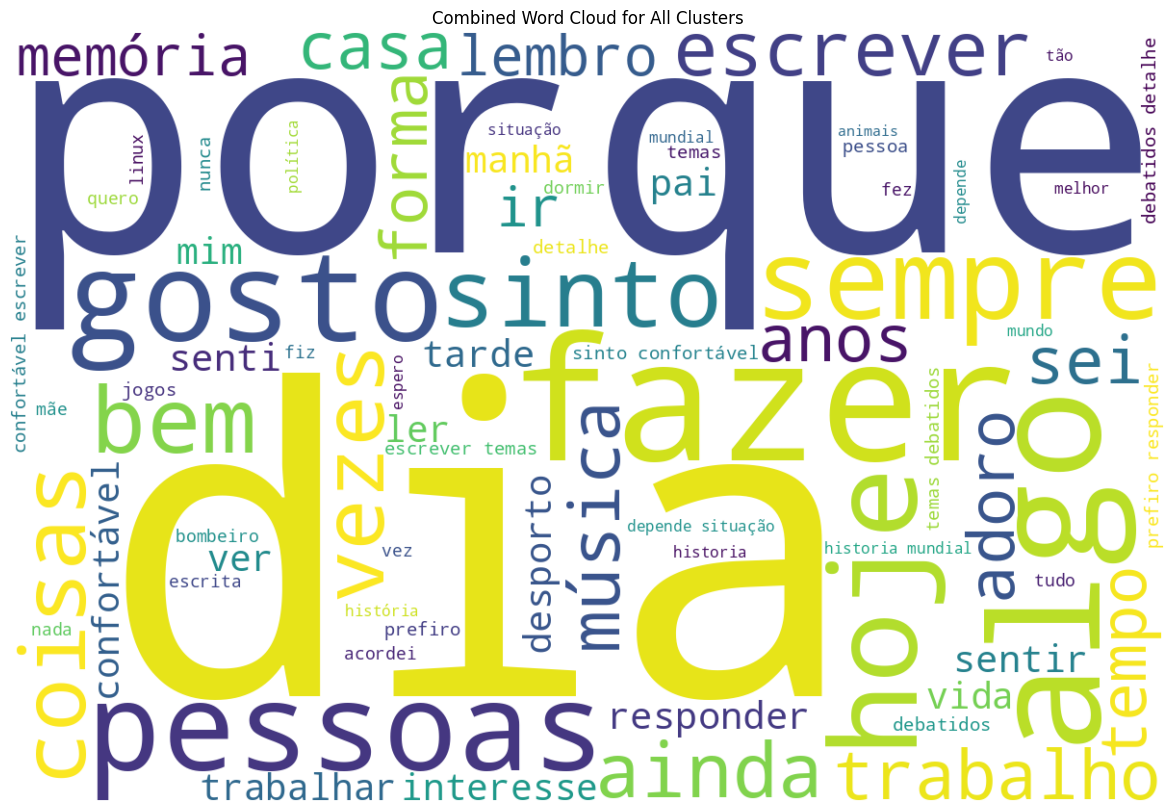

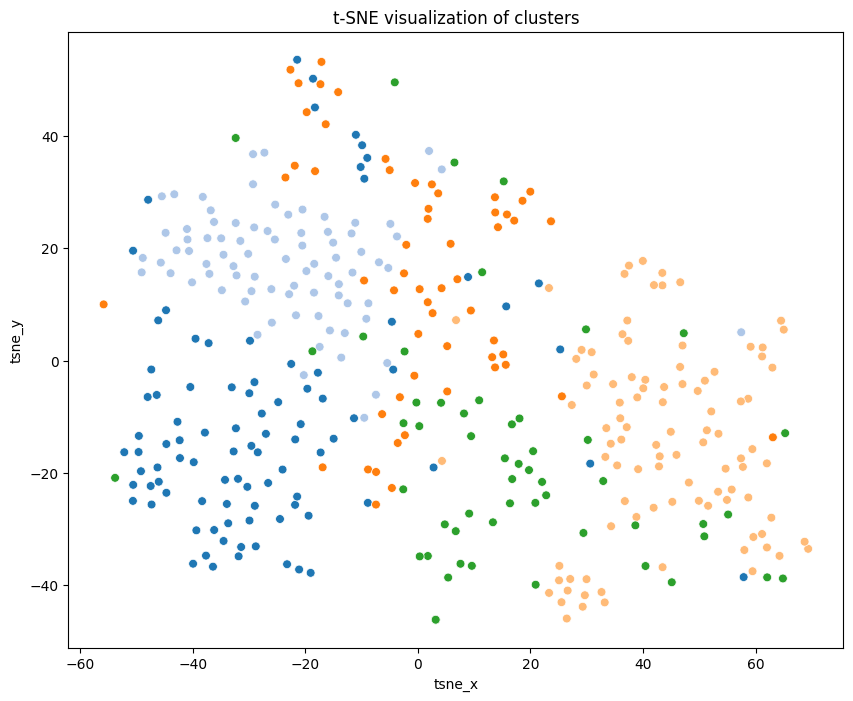

In [17]:
all_status_workflow(df_others, df_others, column, n_clusters=5)

## ADHD vs. Non-ADHD

In [18]:
mask_adhd = (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = ~mask_adhd

df_adhd = df[mask_adhd]
df_others = df[mask_others]

DF shape: (94, 61)

Cluster 0:
['animais', 'tudo', 'nada', 'adoro', 'sempre', 'interesse', 'tão', 'gosto', 'mundo', 'jogo', 'saúde', 'porque', 'especial', 'sindicalista', 'qualquer', 'apenas', 'interesse especial', 'dia', 'música', 'geral']

Cluster 1:
['dia', 'hoje', 'porque', 'trabalho', 'semana', 'casa', 'acordei', 'primeira', 'trabalhar', 'ainda', 'bem', 'sinto', 'nada', 'cansada', 'noite', 'apresentação', 'fazer', 'ir', 'tarde', 'feliz']

Cluster 2:
['fazer', 'prefiro', 'prefiro fazer', 'linux', 'gosto', 'consigo', 'correr', 'gosto correr', 'ler', 'objetivo', 'objetivo pergunta', 'percebi', 'percebi objetivo', 'pergunta', 'nada', 'porque', 'tudo', 'consigo focada', 'focada', 'focada relaxa']

Cluster 3:
['ainda', 'vida', 'pessoas', 'mim', 'dia', 'entristece', 'muitas', 'porque', 'comigo', 'anos', 'escola', 'pessoa', 'irmão', 'sempre', 'uns', 'mãe', 'sinto', 'memória', 'onde', 'pai']

Cluster 4:
['phda', 'pessoas', 'anos', 'vida', 'perceber', 'pensamentos', 'comportamento pessoas',

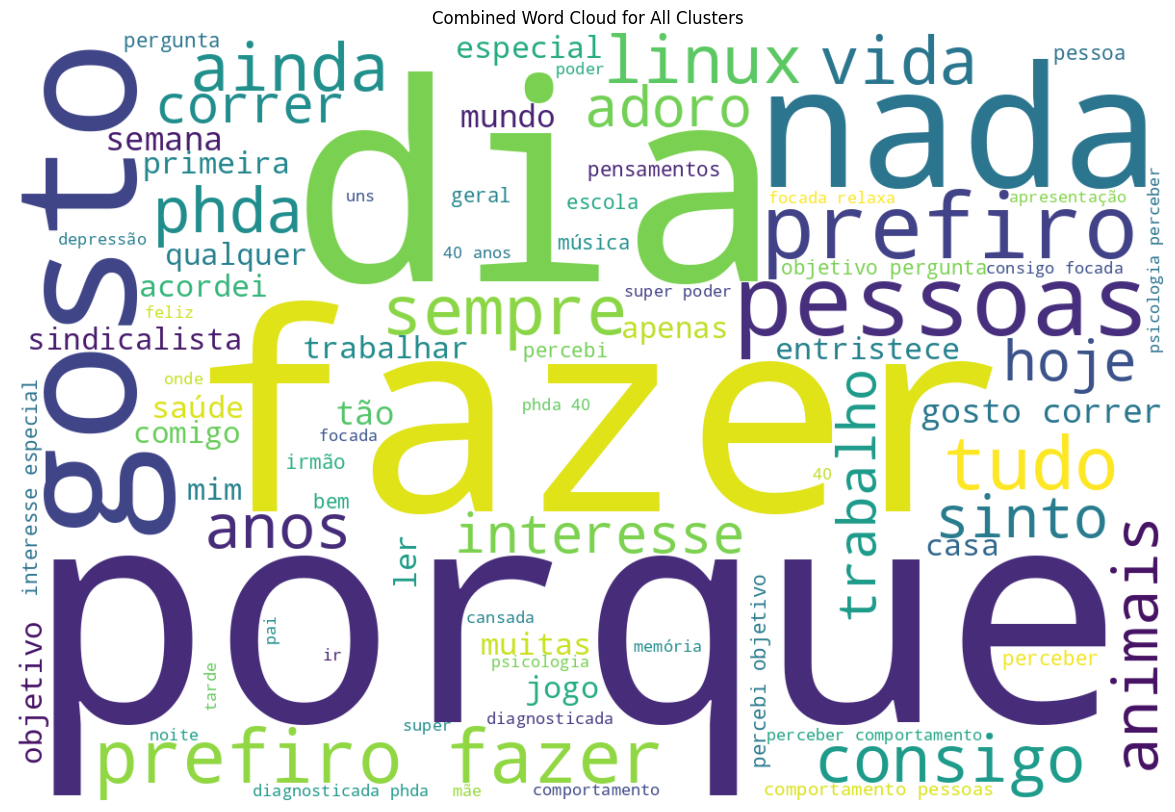

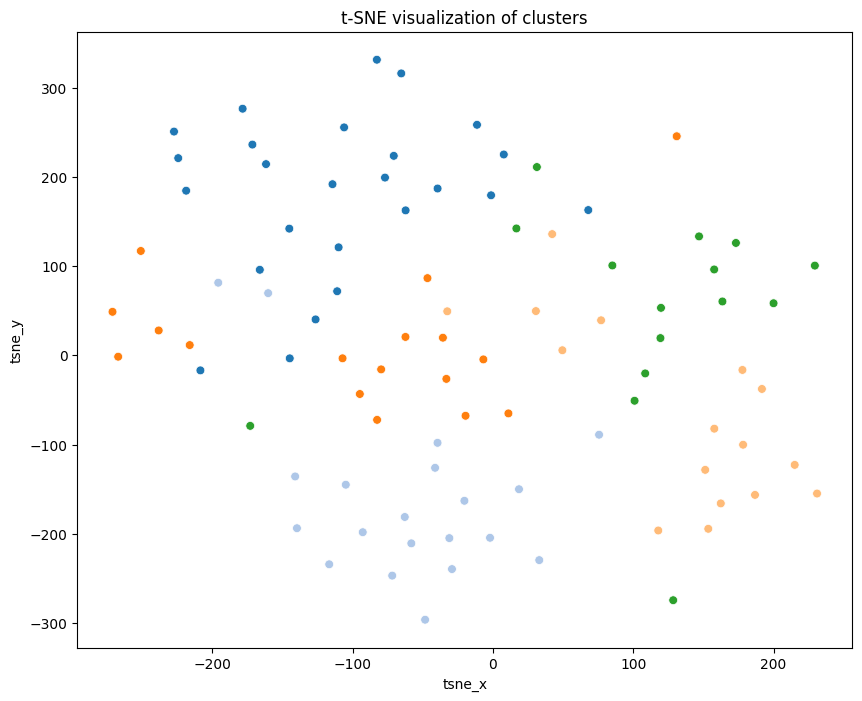

In [19]:
all_status_workflow(df_adhd, df_adhd, column)

DF shape: (353, 61)

Cluster 0:
['escrita', 'bombeiro', 'história', 'porque', 'animais', 'gosto', 'historia', 'pessoas', 'mundo', 'ver', 'dia', 'forma', 'espero', 'política', 'onde', 'jogo', 'jogos', 'historia mundial', 'mundial', 'amo']

Cluster 1:
['escrever', 'sinto', 'sei', 'responder', 'confortável', 'sinto confortável', 'prefiro', 'confortável escrever', 'debatidos', 'debatidos detalhe', 'detalhe', 'escrever temas', 'temas', 'temas debatidos', 'prefiro responder', 'dia', 'nenhuma', 'vezes', 'pessoas', 'fazer']

Cluster 2:
['gosto', 'porque', 'música', 'fazer', 'dia', 'adoro', 'forma', 'coisas', 'algo', 'bem', 'sentir', 'desporto', 'ler', 'vida', 'sempre', 'sinto', 'ver', 'pessoas', 'interesse', 'faz']

Cluster 3:
['dia', 'anos', 'sempre', 'lembro', 'memória', 'pai', 'hoje', 'algo', 'fazer', 'porque', 'mim', 'melhor', 'nunca', 'mãe', 'pessoas', 'pessoa', 'fez', 'tudo', 'altura', 'vez']

Cluster 4:
['dia', 'fazer', 'hoje', 'porque', 'trabalho', 'ir', 'casa', 'tarde', 'tempo', 'sent

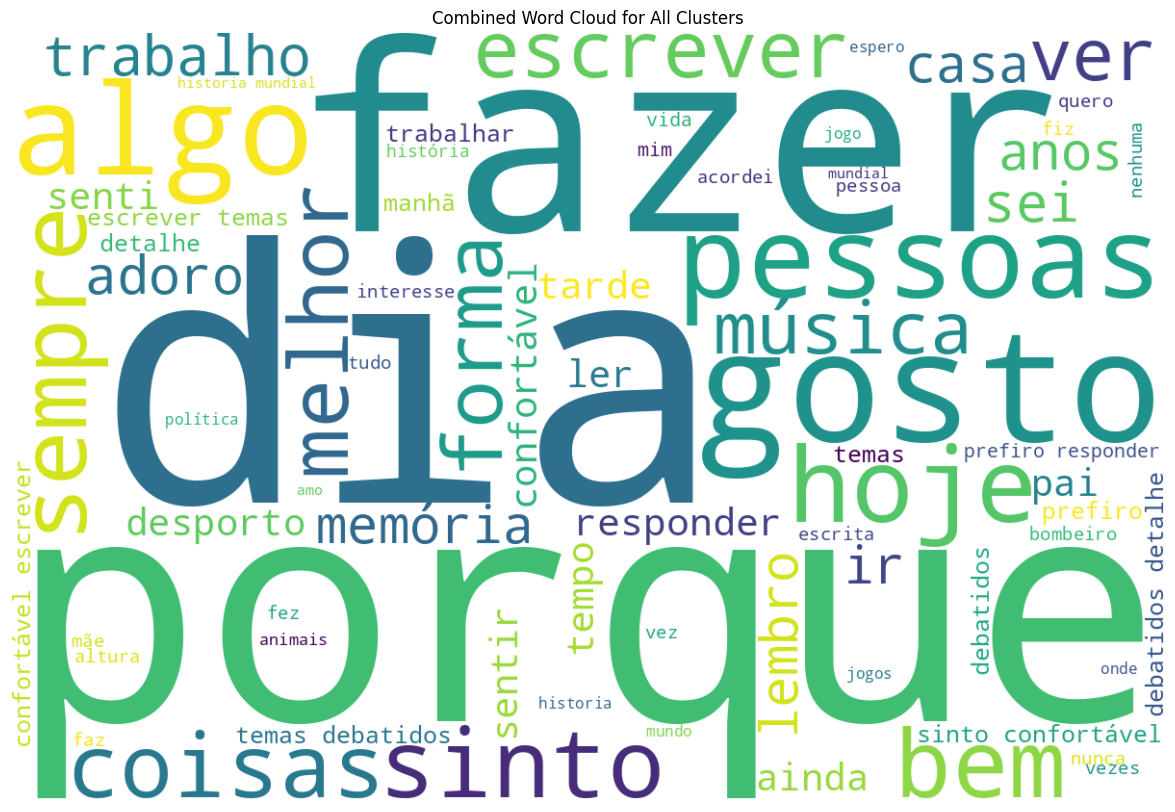

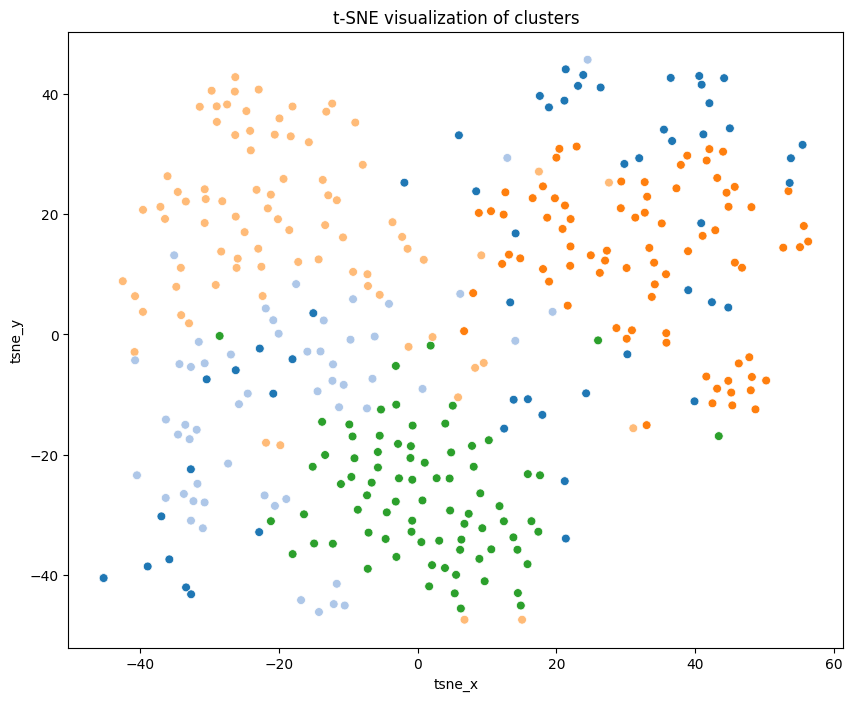

In [20]:
all_status_workflow(df_others, df_others, column)

## Women with ADHD vs. Men with ADHD

In [21]:
mask_women_adhd = (df['sex']=="Feminino") & (df['adhd_diagnosis']=="Sim, diagnosticado")
mask_others = (df['sex']=="Masculino") & (df['adhd_diagnosis']=="Sim, diagnosticado")

df_women_adhd = df[mask_women_adhd]
df_men_adhd = df[mask_others]

DF shape: (65, 61)

Cluster 0:
['tudo', 'saúde', 'tão', 'interesse', 'geral', 'especial', 'interesse especial', 'cinema', 'cinema surrealismo', 'minerais', 'minerais música', 'música', 'música cinema', 'necrópoles', 'necrópoles minerais', 'pedras', 'pedras necrópoles', 'surrealismo', 'incrível', 'mundo']

Cluster 1:
['dia', 'porque', 'pessoas', 'hoje', 'consigo', 'sinto', 'bem', 'vida', 'ainda', 'percebi', 'nunca', 'pq', 'comigo', 'trabalho', 'adoro', 'fazer', 'cansada', 'acordei', 'sei', 'memória']

Cluster 2:
['fazer', 'prefiro', 'prefiro fazer', 'correr', 'gosto', 'gosto correr', 'consigo', 'consigo dar', 'consigo escrever', 'continuidade', 'dar', 'dar continuidade', 'diário', 'diário porque', 'escrever', 'escrever diário', 'porque', 'porque consigo']

Cluster 3:
['phda', 'nada', 'pessoas', 'entristece', 'tudo', 'comportamento', 'sindicalista', 'perceber', 'anos', 'vida', 'sempre', 'comportamento pessoas', 'perceber comportamento', 'psicologia', 'psicologia perceber', '40', '40 anos

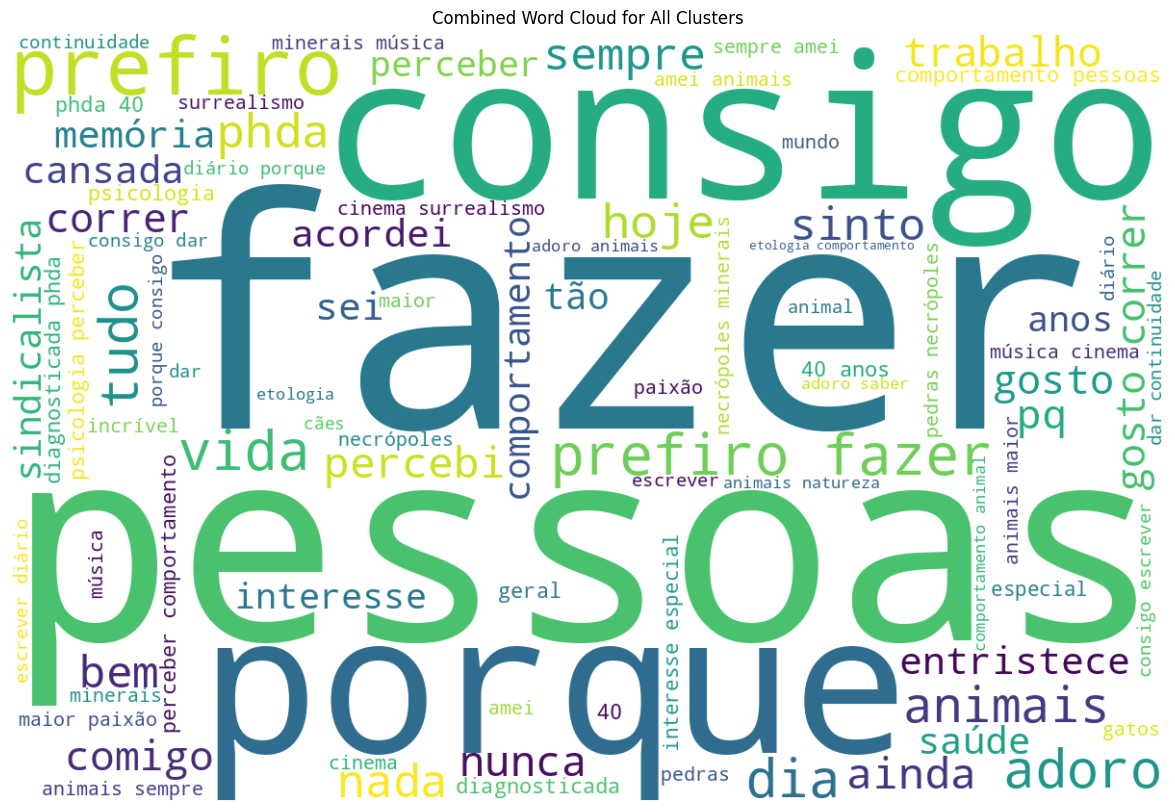

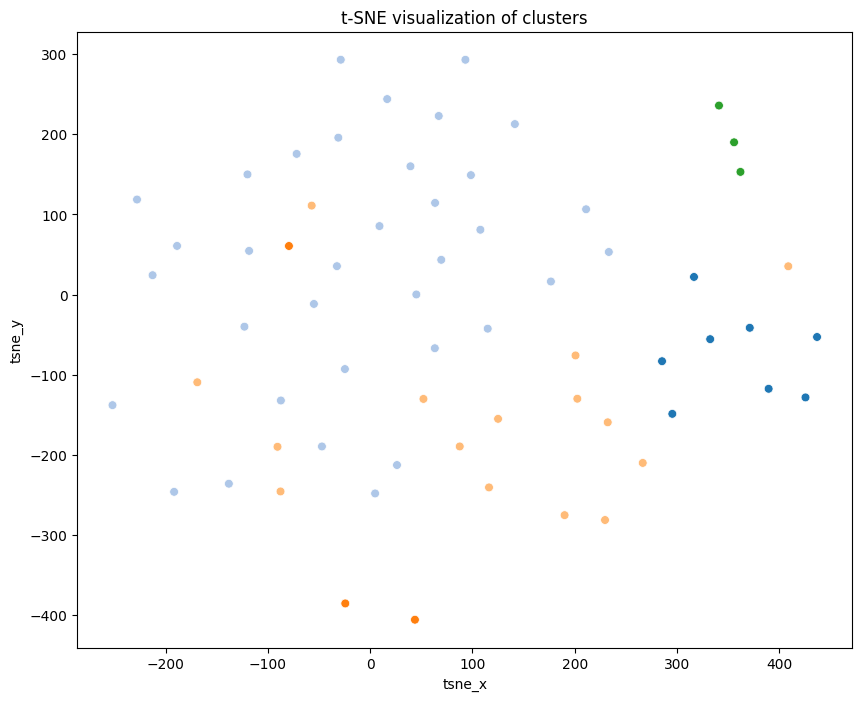

In [22]:
all_status_workflow(df_women_adhd, df_women_adhd, column)

DF shape: (29, 61)

Cluster 0:
['incrivel', 'qualquer', 'estudo', 'apenas', 'filme', 'humana', 'própria', 'maneira', 'técnicas', 'valores', 'considerar', 'imagem', 'animal', 'animal incrivel', 'capacidade', 'capacidade mente', 'construsao', 'construsao incomparavel', 'desenvolver', 'desenvolver sociedade']

Cluster 1:
['poder', 'super', 'super poder', 'phda', 'depressão pensamentos', 'dia', 'diagnosticado', 'diagnosticado recentemente', 'durante', 'durante dia', 'maioritariamente', 'maioritariamente negativos', 'negativos', 'negativos durante', 'pensamentos', 'pensamentos maioritariamente', 'recentemente', 'recentemente depressão', 'depressão', 'medicação']

Cluster 2:
['dia', 'tudo', 'tão', 'nada', 'gosto', 'saber', 'conseguir', 'tentar', 'cabeça', 'capaz', 'capaz lembrar', 'genuinamente', 'genuinamente capaz', 'importante', 'lembrar', 'lembrar nada', 'nada tão', 'tão importante', 'pessoas', 'algo']

Cluster 3:
['primeira', 'jogo', 'porque', 'sempre', 'memórias', 'memórias primeira', 

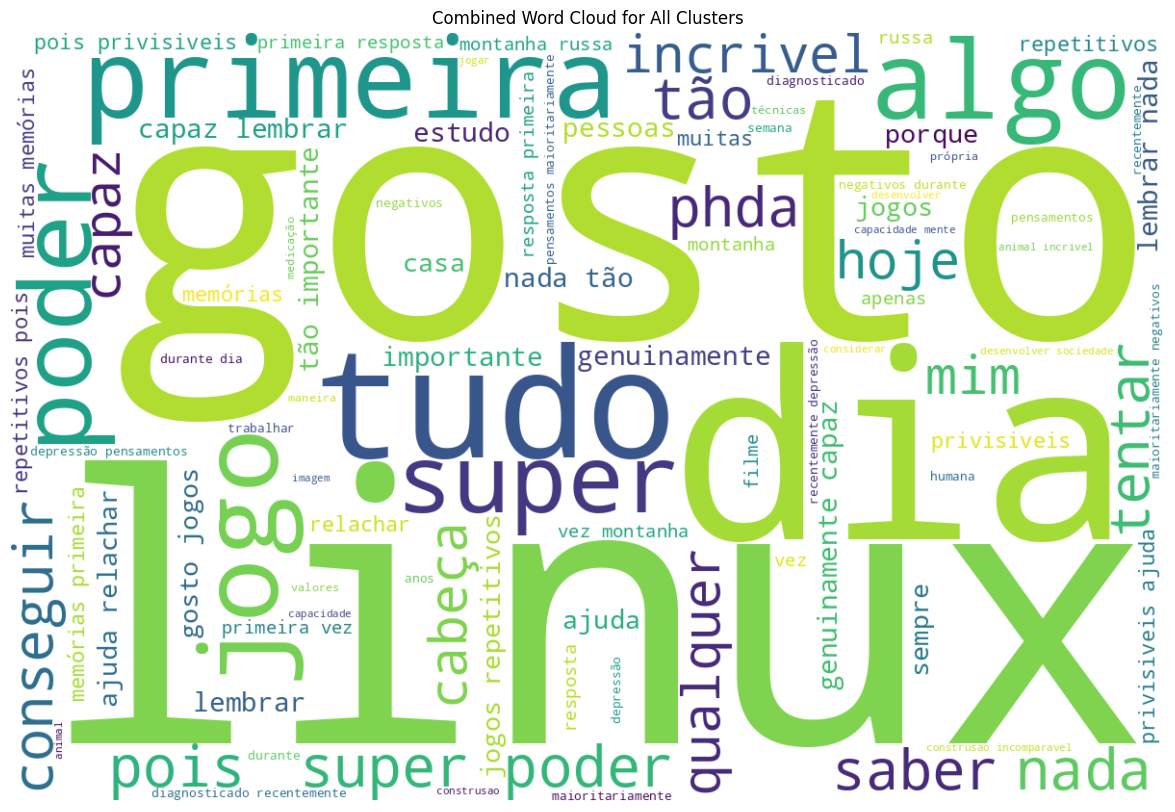

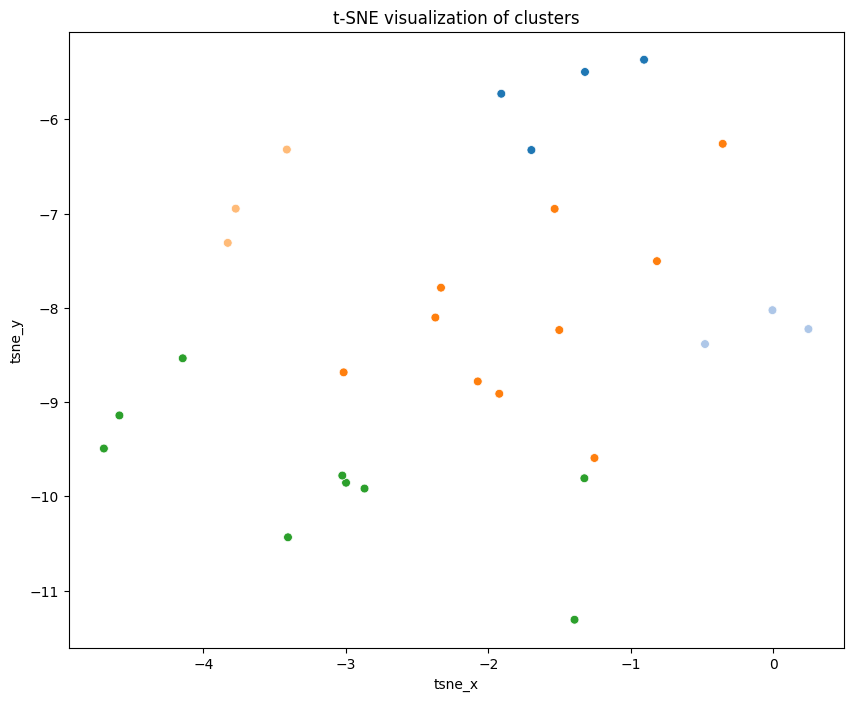

In [23]:
all_status_workflow(df_men_adhd, df_men_adhd, column)

## Women vs. Men

In [24]:
mask_women = (df['sex']=="Feminino")
mask_others = ~mask_women

df_women = df[mask_women]
df_others = df[mask_others]

DF shape: (285, 61)

Cluster 0:
['dia', 'fazer', 'hoje', 'porque', 'trabalho', 'casa', 'tempo', 'ainda', 'bem', 'sinto', 'ir', 'tarde', 'trabalhar', 'acordei', 'manhã', 'cansada', 'senti', 'coisas', 'hoje dia', 'fiquei']

Cluster 1:
['gosto', 'porque', 'adoro', 'dia', 'coisas', 'bem', 'fazer', 'ler', 'música', 'sempre', 'interesse', 'vida', 'pessoas', 'tudo', 'forma', 'mundo', 'conhecer', 'tempo', 'algo', 'sentir']

Cluster 2:
['prefiro', 'fazer', 'responder', 'sei', 'prefiro fazer', 'prefiro responder', 'consigo', 'escrever', 'inspirada', 'pergunta', 'correr', 'gosto', 'gosto correr', 'porque', 'diários', 'hoje', 'aborrece', 'nunca', 'dia', 'tão']

Cluster 3:
['sempre', 'pessoas', 'memória', 'lembro', 'mim', 'vida', 'mãe', 'anos', 'nunca', 'porque', 'fazer', 'tudo', 'vezes', 'pai', 'pessoa', 'algo', 'dia', 'comigo', 'falar', 'todos']

Cluster 4:
['animais', 'pessoas', 'escrita', 'porque', 'phda', 'saúde', 'geral', 'gosto', 'mental', 'anos', 'ver', 'amo', 'adoro', 'depende situação', '

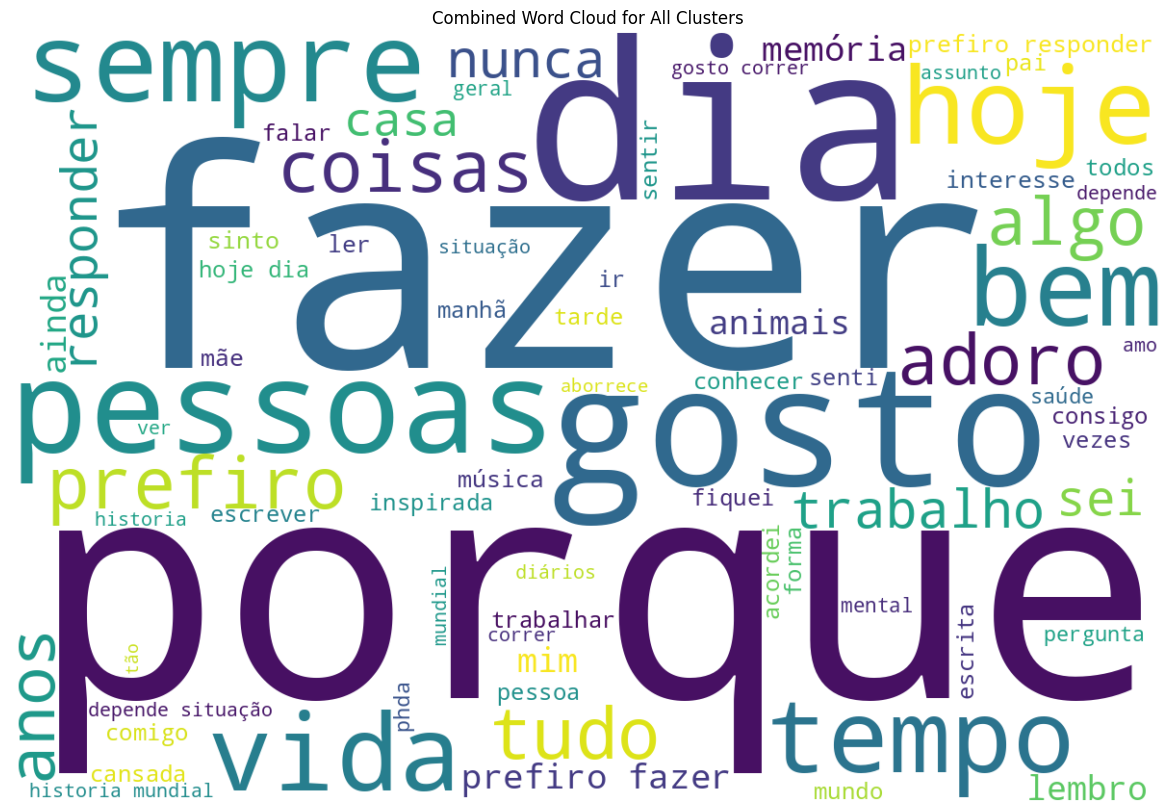

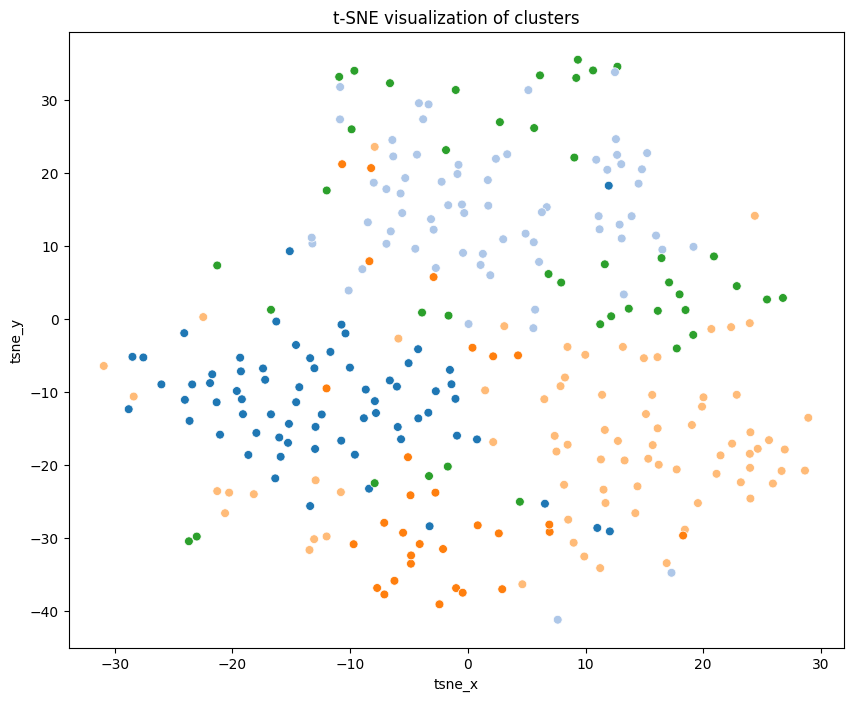

In [25]:
all_status_workflow(df_women, df_women, column)

DF shape: (162, 61)

Cluster 0:
['gosto', 'jogar', 'desporto', 'porque', 'sempre', 'fazer', 'jogos', 'música', 'jogo', 'ver', 'algo', 'tipo', 'desde', 'forma', 'sentir', 'dia', 'sinto', 'qualquer', 'desafio', 'bem']

Cluster 1:
['dia', 'fazer', 'porque', 'hoje', 'tempo', 'tarde', 'ir', 'trabalhar', 'manhã', 'casa', 'senti', 'trabalho', 'fiz', 'bem', 'algo', 'amigos', 'acordei', 'coisas', 'quero', 'melhor']

Cluster 2:
['hoje', 'anos', 'porque', 'dia', 'algo', 'memória', 'pai', 'vez', 'primeira', 'ainda', 'pessoa', 'amigos', 'altura', 'comigo', 'lembro', 'maneira', 'pessoas', 'sempre', 'cabeça', 'pensar']

Cluster 3:
['escrever', 'sinto', 'confortável', 'detalhe', 'confortável escrever', 'debatidos', 'debatidos detalhe', 'escrever temas', 'sinto confortável', 'temas', 'temas debatidos', 'dia', 'nada', 'algo', 'tudo', 'nada escrever', 'vida', 'situações', 'saber', 'pessoas']

Cluster 4:
['bombeiro', 'linux', 'nenhuma', 'acusação', 'acusação realizei', 'realizei', 'jogo', 'personagem', 'a

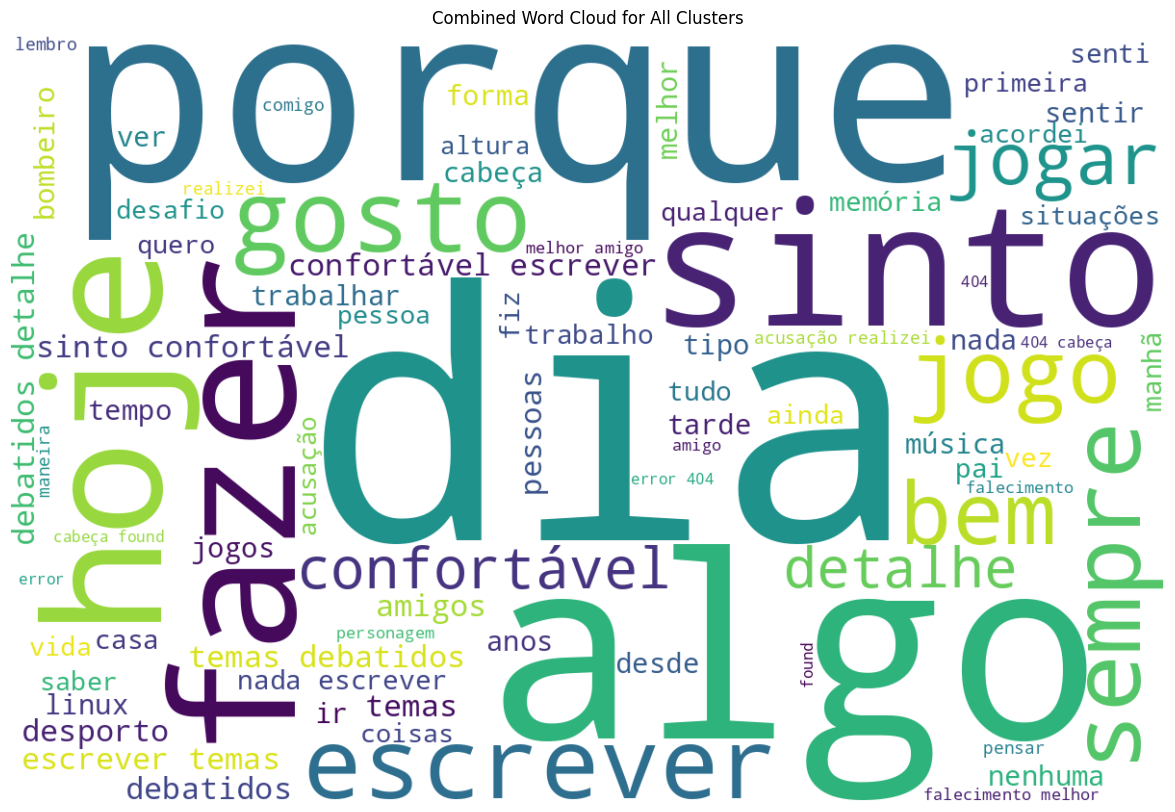

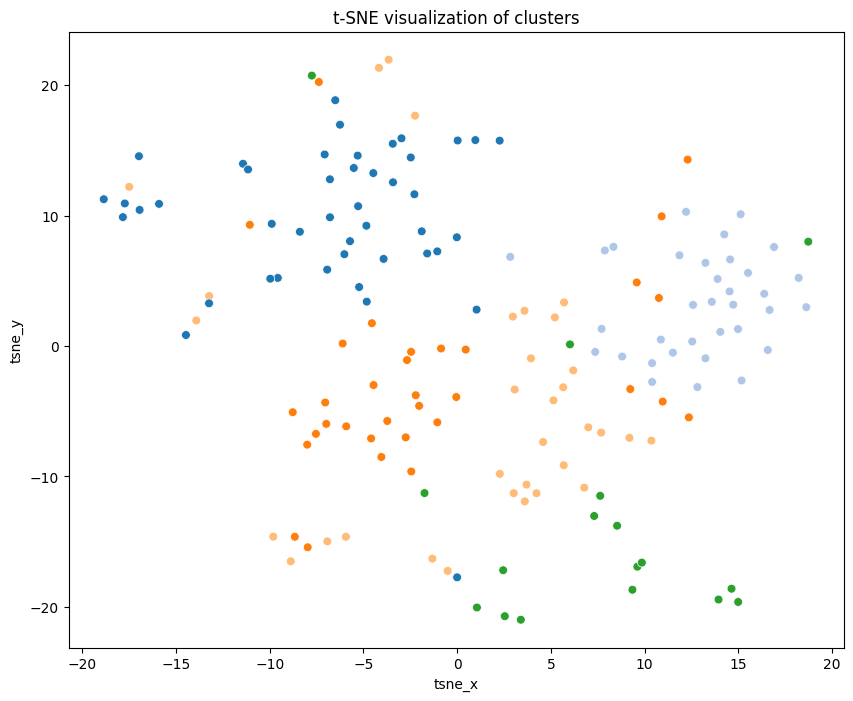

In [26]:
all_status_workflow(df_others, df_others, column)